In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict

# PRE PROCESSING

In [45]:
## DEFINE INPUT PARAMETERS
# defining velocity, density, and viscocity for fluid
u0 = 1 # lid velocity
rho0 = 1
nu0 = 0.01
N = 440

In [296]:
## MODEL INPUT CREATION METHODS
def Uniform(u0, N):
    """
    Uniform colocation and BC

    Args: 
        u0 : Lid velocity
        N : number of collocation points you want to use

    Returns: As Tensors (Type Double)
        X : collocation points [x, y] #NOTE collocation points currently overlap with BC points
        BC_X : BC points [x, y]
        BC_Y : training output [u, v] at BCs
    """
    d = 1/np.sqrt(N)  # d : Δx ,Δy between each data point
    x = torch.arange(0, 1+d, d)
    y = torch.arange(0, 1+d, d)

    X = torch.stack(torch.meshgrid(x,y)).reshape(2,-1).T

    b_left = torch.stack(torch.meshgrid(x[0], y)).reshape(2,-1).T  # x = 0, y = var, left wall
    b_right = torch.stack(torch.meshgrid(x[-1],y)).reshape(2,-1).T
    b_bottom = torch.stack(torch.meshgrid(x, y[0])).reshape(2,-1).T
    b_top = torch.stack(torch.meshgrid(x, y[-1])).reshape(2,-1).T

    BC_X = torch.cat([b_left, b_bottom, b_right, b_top])

    # Get wall velocities in form of [u,v]
    walls_Y = torch.zeros(b_left.size())

    # Get BC for lid driven component
    wall_lid = torch.zeros(b_top.size()[0], b_top.size()[1])
    wall_lid[:,0] = u0

    BC_Y = torch.cat([walls_Y, walls_Y, walls_Y, wall_lid])

    return X, BC_X, BC_Y

def Random(u0, N):
    """
    Random colocation and BC

    Args: 
        u0 : Lid velocity
        N : number of collocation points you want to use

    Returns: As Tensors (Type Double)
        X : collocation points [x, y] #NOTE collocation points currently overlap with BC points
        BC_X : BC points [x, y]
        BC_Y : training output [u, v] at BCs
    """
    X = np.random.rand(N, 2)
    X = torch.tensor(X)
    Y = torch.tensor(np.zeros((N, 2)))
    
    BC_ub = np.random.rand(N//2, 2)  # top-bottom boundaries
    BC_ub[..., 1] = np.round(BC_ub[..., 1])          # y-position is 0 or 1
    BC_lr = np.random.rand(N//2, 2)  # left-right boundaries
    BC_lr[..., 0] = np.round(BC_lr[..., 0])          # x-position is 0 or 1
    BC_X = np.random.permutation(np.concatenate([BC_ub, BC_lr]))
    BC_X = torch.tensor(BC_X)
    
    # create training output
    # Zeros creation here if i decide to make the PDE output here
    zeros = np.zeros((N, 2))
    BC_Y = np.zeros((N, 2))
    BC_Y[..., 0] = u0 * np.floor(BC_X[..., 1])
    BC_Y = torch.tensor(BC_Y)
    
    return X.float(), BC_X.float(), BC_Y.float()
        

In [297]:
## Compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True
    )[0]
def compute_gradients(model, xy):
    """
    Args:
        model : PyTorch neural network, outputs [psi, p] for input xy
        xy    : tensor of shape (N, 2), # when setting up model set requires_grad=True

    Returns:
        psi : stream function
        p_grads : (p, p_x, p_y) as a tuple
        u_grads : (u, u_x, u_y, u_xx, u_yy) as a tuple
        v_grads : (v, v_x, v_y, v_xx, v_yy) as a tuple
    """
    # create a clone so we dont change the original tensor
    # detatch the xy data from previous gradients so it can be evaluated in isolation
    xy = xy.clone().detach().requires_grad_(True)  
    x = xy[:, 0:1]
    y = xy[:, 1:2]

    # Join the pre sliced tensors x and y and forward pass for modelx to get psi and p
    psi_p = model(torch.cat([x, y], dim=1))
    psi = psi_p[:, 0:1]
    p   = psi_p[:, 1:2]

    # First-order derivatives
    u =  grad(psi, y)
    v = -grad(psi, x)
    p_x = grad(p, x)
    p_y = grad(p, y)

    # Second-order derivatives
    u_x = grad(u, x)
    u_y = grad(u, y)
    v_x = grad(v, x)
    v_y = grad(v, y)

    # Third-order derivatives
    u_xx = grad(u_x, x)
    u_yy = grad(u_y, y)
    v_xx = grad(v_x, x)
    v_yy = grad(v_y, y)
    
    p_grads = (p, p_x, p_y)
    u_grads = (u, u_x, u_y, u_xx, u_yy)
    v_grads = (v, v_x, v_y, v_xx, v_yy)

    return psi, p_grads, u_grads, v_grads

# MODEL CREATION

In [298]:
## NETWORK CREATION (Layers and fwdpass)

class Net(nn.Module):
    def __init__(
            self,
            N_input,
            N_hidden_arr,
            N_output,
            activation = nn.Tanh
    ):
        super(Net, self).__init__()  # Create network

        # Create input layer w/ activation function
        layers = [('Input', nn.Linear(N_input, N_hidden_arr[0]))]
        layers.append(('Input activation', activation()))

        # Create hidden layers
        for i in range(len(N_hidden_arr)-1):
            layers.append(
                ("Hidden %d" % (i+1), nn.Linear(N_hidden_arr[i], N_hidden_arr[i+1]))
            )
            layers.append(('Hidden activation %d' % (i+1), activation()))
        layers.append(('Output', nn.Linear(N_hidden_arr[-1], N_output)))
        layerdict = OrderedDict(layers)
        self.layers = nn.Sequential(layerdict)

    
    def forward(self, x):
        y = self.layers(x)
        return y

In [299]:
## LOSS FUNCTION

def navier_stokes_loss(model,X):
    """
    calculates steady navier stokes residuals at collocation points

    Args: 
        model : whatever model calls this function
        X : input collocation [x,y] coords as defined in models data creation

    Returns: 
        tensor of all collocation point residuals
    """
    _, p_grads, u_grads, v_grads = compute_gradients(model, X)
    _, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    #compute PDE residuals
    u_eqn = u*u_x + v*u_y + p_x/rho0 - nu0*(u_xx + u_yy)
    v_eqn = u*v_x + v*v_y + p_y/rho0 - nu0*(v_xx + v_yy)
    

    # combine into one tensor
    return torch.cat([u_eqn, v_eqn,(u_x+u_y)], dim=1)
    
def BC_loss(model,BC_X):
    """
    calculates u and v at boundary conditions

    Args: 
        model : whatever model calls this function
        BC_X : Input Boundary conditions [x,y] coords as defined in models data creation
        
    Returns: 
        tensor of u,v at all boundary condition coords
    """
    psi_bnd, _, u_grads, v_grads = compute_gradients(model,BC_X)
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    return torch.cat([u, v], dim=1)
    
    


In [336]:
## create neural network

class PINN:
    def __init__(self):
        ### Need to change this to check if gpu available as well
        device = torch.device("cpu")
        print("Using CPU")
        self.model = Net(
            N_input=2,
            N_hidden_arr=[32,16,16,32],
            N_output = 2
        ).to(device)
    
        # DATA CREATION (change function call for different data, options: Uniform(),Random())
        self.X, self.BC_X, self.BC_Y =  Uniform(u0,N)

        # copy and seperate tensors into format for loss calculations
        self.X = self.X.clone().detach().requires_grad_(True)
        self.BC_X = self.BC_X.clone().detach().requires_grad_(True)

        
        # OPTIMISERS
        self.optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1.0,
            max_iter = 75*10**3,
            max_eval = 75*10**3,
            history_size=50,
            tolerance_change=1e-7,
            tolerance_grad=1e-7,
            line_search_fn="strong_wolfe"
        )
        self.adam = torch.optim.Adam(self.model.parameters())

        
        self.loss_fn = nn.MSELoss()

        # Counter for printing loss
        self.iter =1
        
    # Loss
    def compute_loss(self):
        # Compute PDE residuals at collocation points
        residuals = navier_stokes_loss(self.model, self.X)
        ru, rv, conservation  = residuals[:, 0:1], residuals[:, 1:2], residuals[:, 2:3]

        # PDE loss (residuals against tensor of zeros)
        # ! conservation loss is currently being excluded as training always traps in a local minima
        pde_loss = self.loss_fn(ru, torch.zeros_like(ru)) + self.loss_fn(rv, torch.zeros_like(rv))#+self.loss_fn(conservation, torch.zeros_like(conservation))

        # BC loss
        bc_loss = BC_loss(self.model,self.BC_X)
        bc_loss = self.loss_fn(bc_loss,self.BC_Y)
        
        
        total_loss = pde_loss + bc_loss

        # print the loss
        if self.iter % 100 == 0:
            print(f"Iteration {self.iter:5}, Total Loss {total_loss:.9f}")
        self.iter+= 1
        
        return total_loss
    
    def train(self, adam_epochs=300, lbfgs_epochs=10):
        self.model.train()

        for epoch in range(adam_epochs):
            self.adam.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            self.adam.step()

            # extra printing of loss for when adam optimiser in use
            if epoch % 50 == 0:
                with torch.inference_mode():  
                    print(f"[Adam] Step {epoch:4}, Loss = {loss.item():.6e}")
        
        
        for epoch in range(lbfgs_epochs):
            def closure():
                self.optimiser.zero_grad()
                loss = self.compute_loss()
                loss.backward()
                return loss

            self.optimiser.step(closure)
            
        


    def eval(self):
        self.model.eval()

        



In [337]:
test = PINN()


Using CPU


In [338]:
test.train()


[Adam] Step    0, Loss = 1.290026e-01
[Adam] Step   50, Loss = 6.075662e-02
Iteration   100, Total Loss 0.029415853
[Adam] Step  100, Loss = 2.904357e-02
[Adam] Step  150, Loss = 1.689334e-02
Iteration   200, Total Loss 0.015053546
[Adam] Step  200, Loss = 1.503340e-02
[Adam] Step  250, Loss = 1.428182e-02
Iteration   300, Total Loss 0.013932562
Iteration   400, Total Loss 0.012852545
Iteration   500, Total Loss 0.012502601
Iteration   600, Total Loss 0.012328535
Iteration   700, Total Loss 0.011834459
Iteration   800, Total Loss 0.011271564
Iteration   900, Total Loss 0.010881378
Iteration  1000, Total Loss 0.010623782
Iteration  1100, Total Loss 0.010511538
Iteration  1200, Total Loss 0.010327053
Iteration  1300, Total Loss 0.010083596
Iteration  1400, Total Loss 0.009871580
Iteration  1500, Total Loss 0.009720216
Iteration  1600, Total Loss 0.009560964
Iteration  1700, Total Loss 0.009415707
Iteration  1800, Total Loss 0.009258334
Iteration  1900, Total Loss 0.008993052
Iteration  2

# POST PROCESSING

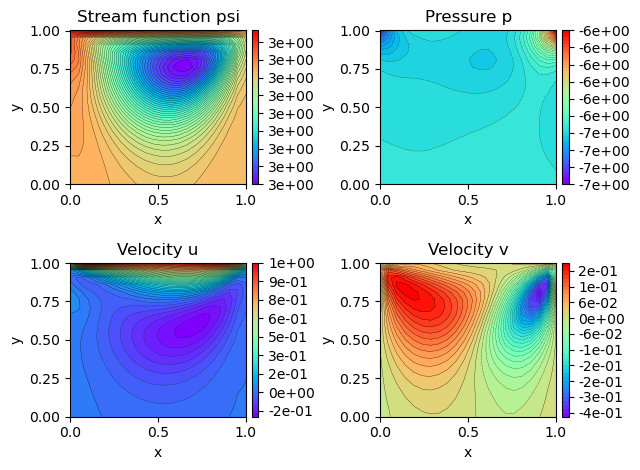

In [339]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
X, BC_X, BC_Y = Uniform(u0, N)
    
X = X.clone().detach().requires_grad_(True)      
x = X[:, 0:1]
y = X[:, 1:2]

# forward pass of the model !!! fwd pass outside eval/inference is okay as long as you dont .backward()
y_preds = test.model(X)
psi = y_preds[:, 0:1]   # stream function
p   = y_preds[:, 1:2]   #pressure

#mini tensor gradient function for getting u,v
psi_grads = torch.autograd.grad(
    outputs=psi,
    inputs=X,
    grad_outputs=torch.ones_like(psi),
    create_graph=False,   
    retain_graph=False
)[0]
u = psi_grads[:, 1:2]          
v = -psi_grads[:, 0:1] 

# convert to array for postprocessing
psi_np = psi.detach().numpy()
p_np   = p.detach().numpy()
u_np   = u.detach().numpy()
v_np   = v.detach().numpy()
x_np   = X[:, 0:1].detach().numpy()
y_np   = X[:, 1:2].detach().numpy()

#reshape for grid plotting
n = int(np.sqrt(p_np.shape[0]))
psi_grid = psi_np.reshape(n, n)
p_grid   = p_np.reshape(n, n)
u_grid   = u_np.reshape(n, n)
v_grid   = v_np.reshape(n, n)
x_grid   = x_np.reshape(n, n)
y_grid   = y_np.reshape(n, n)

def contour(grid, x, y, z, title, levels=50):
    """
    Contour plot.

    Args:
        grid: plot position in subplot
        x: x-array (x coords)
        y: y-array  (y coords)
        z: z-array (engineering value at [x,y])
        title: title 
        levels: number of contour lines.
    """

    vmin, vmax = z.min(), z.max()
    #plt.figure(figsize=(5,4))
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    plt.xlabel("x")
    plt.ylabel("y")
   
gs = GridSpec(2,2)
contour(gs[0, 0],x_grid, y_grid, psi_grid, "Stream function psi")
contour(gs[0, 1],x_grid, y_grid, p_grid, "Pressure p")
contour(gs[1, 0],x_grid, y_grid, u_grid, "Velocity u")
contour(gs[1, 1],x_grid, y_grid, v_grid, "Velocity v")
plt.tight_layout()
plt.show()